In [2]:
!pip install -q kaggle
!pip install -q tensorflow matplotlib seaborn scikit-learn opencv-python

In [3]:
# Create Kaggle directory
!mkdir -p ~/.kaggle

# Move kaggle.json if it is already uploaded
!cp kaggle.json ~/.kaggle/

# Set correct permissions
!chmod 600 ~/.kaggle/kaggle.json

# Verify
!ls ~/.kaggle

kaggle.json


In [3]:
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database

Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database
License(s): copyright-authors
 96% 746M/778M [00:03<00:00, 208MB/s]
100% 778M/778M [00:03<00:00, 210MB/s]


In [4]:
!unzip -q covid19-radiography-database.zip
!ls

covid19-radiography-database.zip  kaggle.json
COVID-19_Radiography_Dataset	  sample_data


In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import EfficientNetB3
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

IMG_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 15

CLASSES = ['COVID']

print("TensorFlow:", tf.__version__)
print("GPU:", tf.config.list_physical_devices('GPU'))


TensorFlow: 2.19.0
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
DATASET_PATH = "COVID-19_Radiography_Dataset"

In [5]:
def load_images(base_path):
    X, y = [], []

    for idx, cls in enumerate(CLASSES):
        img_dir = os.path.join(base_path, cls, "images")
        print(f"Loading images from class: {cls}")

        # Safety check
        if not os.path.exists(img_dir):
            print(f"⚠️ Directory not found: {img_dir}")
            continue

        for img_name in os.listdir(img_dir):
            img_path = os.path.join(img_dir, img_name)

            # Read image
            img = cv2.imread(img_path)
            if img is None:
                continue  # skip corrupted or non-image files

            # Preprocessing
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            img = img.astype(np.float32) / 255.0

            X.append(img)
            y.append(idx)

    return np.array(X, dtype=np.float32), np.array(y)

# Load dataset
X, y = load_images(DATASET_PATH)
print("✅ Dataset loaded successfully!")
print("X shape:", X.shape)
print("y shape:", y.shape)

Loading images from class: COVID
✅ Dataset loaded successfully!
X shape: (3616, 224, 224, 3)
y shape: (3616,)


In [6]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

y_train_cat = tf.keras.utils.to_categorical(y_train, 4)
y_val_cat   = tf.keras.utils.to_categorical(y_val, 4)
y_test_cat  = tf.keras.utils.to_categorical(y_test, 4)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

Train: (2531, 224, 224, 3) Val: (542, 224, 224, 3) Test: (543, 224, 224, 3)


In [7]:
def transformer_encoder(x, num_heads=8, key_dim=64, ff_dim=512, dropout=0.2):
    attn = layers.MultiHeadAttention(
        num_heads=num_heads,
        key_dim=key_dim,
        dropout=dropout
    )(x, x)

    x = layers.Add()([x, attn])
    x = layers.LayerNormalization()(x)

    ff = layers.Dense(ff_dim, activation='relu')(x)
    ff = layers.Dense(x.shape[-1])(ff)

    x = layers.Add()([x, ff])
    x = layers.LayerNormalization()(x)

    return x


In [8]:
def build_model():
    inputs = layers.Input(shape=(224, 224, 3))

    # CNN FEATURE EXTRACTOR
    base = EfficientNetB3(
        include_top=False,
        weights='imagenet',
        input_tensor=inputs
    )

    for layer in base.layers[:-30]:
        layer.trainable = False

    x = base.output
    x = layers.GlobalAveragePooling2D()(x)  # 1536-dim

    # ATTENTION MODULE
    q = layers.Dense(512)(x)
    k = layers.Dense(512)(x)
    v = layers.Dense(512)(x)

    q = layers.Reshape((1, 512))(q)
    k = layers.Reshape((1, 512))(k)
    v = layers.Reshape((1, 512))(v)

    x = layers.MultiHeadAttention(
        num_heads=8, key_dim=64
    )(q, k, v)

    # TRANSFORMER ENCODER STACK (4 LAYERS)
    for _ in range(4):
        x = transformer_encoder(x)

    x = layers.GlobalAveragePooling1D()(x)

    # CLASSIFICATION HEAD
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(4, activation='softmax')(x)

    return Model(inputs, outputs, name="Hybrid_CNN_Transformer")

model = build_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "Hybrid_CNN_Transformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │      1,080 │ stem_conv_pad[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        360 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        160 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 40)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 40)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 10)  │        410 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 40)  │        440 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 40)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        960 │ block1a_se_excit

 Total params: 20,671,667 (78.86 MB)

 Trainable params: 13,442,302 (51.28 MB)

 Non-trainable params: 7,229,365 (27.58 MB)

In [9]:
history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)


Epoch 1/15


/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 8, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


159/159 ━━━━━━━━━━━━━━━━━━━━ 152s 485ms/step - accuracy: 0.9630 - loss: 0.1294 - val_accuracy: 1.0000 - val_loss: 0.0138
Epoch 2/15
159/159 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 1.0000 - loss: 1.6876e-04 - val_accuracy: 1.0000 - val_loss: 9.2591e-05
Epoch 3/15
159/159 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 1.0000 - loss: 4.4001e-05 - val_accuracy: 1.0000 - val_loss: 3.2112e-07
Epoch 4/15
159/159 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 1.0000 - loss: 2.5542e-05 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/15
159/159 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 1.0000 - loss: 1.3488e-05 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/15
159/159 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 1.0000 - loss: 1.1949e-05 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/15
159/159 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 1.0000 - loss: 5.2605e-06 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/15
159/159 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/st

In [10]:
y_pred = np.argmax(model.predict(X_test), axis=1)

print(classification_report(y_test, y_pred, target_names=CLASSES))


/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 8, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step
              precision    recall  f1-score   support

       COVID       1.00      1.00      1.00       543

    accuracy                           1.00       543
   macro avg       1.00      1.00      1.00       543
weighted avg       1.00      1.00      1.00       543



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


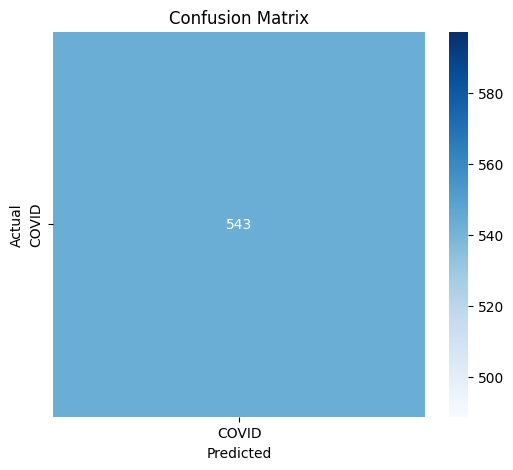

In [11]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm, annot=True, fmt='d',
    xticklabels=CLASSES,
    yticklabels=CLASSES,
    cmap='Blues'
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [12]:
model.save("Hybrid_CNN_Transformer_COVID19.h5")
print("Model saved successfully!")

Model saved successfully!
